In [0]:
## This end-to-end walkthrough trains a logistic regression model using the tf.estimator API. The model is often used as a baseline for other, more complex, algorithms.
# Titanic!
!pip install -q sklearn

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

In [3]:
!pip install -q tensorflow==2.0.0-beta0
import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf

     |████████████████████████████████| 87.9MB 46.4MB/s 
     |████████████████████████████████| 3.1MB 43.6MB/s 
     |████████████████████████████████| 501kB 59.2MB/s 


In [0]:
# Load dataset
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [5]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [6]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [7]:
dftrain.shape[0], dfeval.shape[0]

(627, 264)

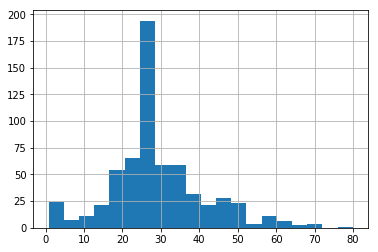

In [8]:
dftrain.age.hist(bins=20)

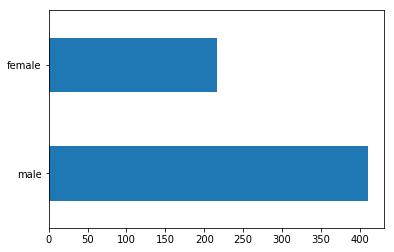

In [9]:
dftrain.sex.value_counts().plot(kind='barh')

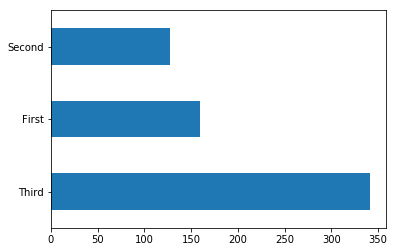

In [10]:
dftrain['class'].value_counts().plot(kind='barh')

Text(0.5, 0, '% survive')

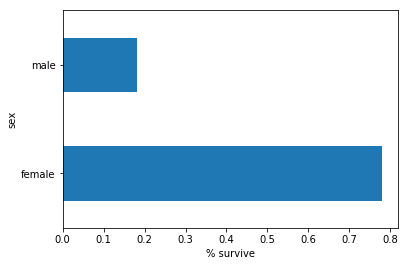

In [13]:
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')

In [0]:
# Estimators use a system called feature columns to describe how the model should interpret each of the raw input features.
# An Estimator expects a vector of numeric inputs, and feature columns describe how the model should convert each feature.
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 'embark_town', 'alone']

NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
    vocabulary = dftrain[feature_name].unique()
    feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))
    

In [0]:
# The input_function specifies how data is converted to a tf.data.Dataset that feeds the input pipeline in a streaming fashion.
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
    def input_function():
        ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
        if shuffle:
            ds = ds.shuffle(1000)
        ds = ds.batch(batch_size).repeat(num_epochs)
        return ds
    return input_function

train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

In [17]:
ds = make_input_fn(dftrain, y_train, batch_size=10)()
for feature_batch, label_batch in ds.take(1):
    print(list(feature_batch.keys()))
    print()
    print(feature_batch['class'].numpy())
    print()
    print(label_batch.numpy())

['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck', 'embark_town', 'alone']

[b'First' b'Second' b'Second' b'Third' b'Third' b'Third' b'Third' b'Third'
 b'Third' b'Third']

[1 0 1 0 1 1 0 1 0 0]


In [20]:
age_column = feature_columns[7]
tf.keras.layers.DenseFeatures([age_column])(feature_batch).numpy()

array([[38.  ],
       [57.  ],
       [42.  ],
       [18.  ],
       [22.  ],
       [ 4.  ],
       [ 9.  ],
       [ 0.75],
       [14.  ],
       [45.  ]], dtype=float32)

In [21]:
gender_column = feature_columns[0]
tf.keras.layers.DenseFeatures([tf.feature_column.indicator_column(gender_column)])(feature_batch).numpy()

W0615 08:34:55.102622 140052797949824 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/feature_column/feature_column_v2.py:2655: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0615 08:34:55.105887 140052797949824 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/feature_column/feature_column_v2.py:4215: IndicatorColumn._variable_shape (from tensorflow.python.feature_column.feature_column_v2) is deprecated and will be removed in a future version.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
W0615 08:34:55.108401 140052797949824 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/feature_column/feature_column_v2.py:4270: VocabularyListCateg

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [22]:
linear_est = tf.estimator.LinearClassifier(feature_columns = feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)

{'accuracy': 0.7651515, 'accuracy_baseline': 0.625, 'auc': 0.807989, 'auc_precision_recall': 0.7769074, 'average_loss': 0.508765, 'label/mean': 0.375, 'loss': 0.49930033, 'precision': 0.72839504, 'prediction/mean': 0.33587047, 'recall': 0.5959596, 'global_step': 200}


In [0]:
age_x_gender = tf.feature_column.crossed_column(['age', 'sex'], hash_bucket_size=100)

In [24]:
derived_feature_columns = [age_x_gender]
linear_est = tf.estimator.LinearClassifier(feature_columns = feature_columns + derived_feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)

{'accuracy': 0.7537879, 'accuracy_baseline': 0.625, 'auc': 0.8428834, 'auc_precision_recall': 0.7870918, 'average_loss': 0.49065134, 'label/mean': 0.375, 'loss': 0.48574957, 'precision': 0.6465517, 'prediction/mean': 0.45049936, 'recall': 0.75757575, 'global_step': 200}


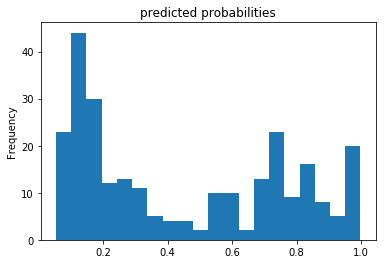

In [26]:
pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')

(0, 1.05)

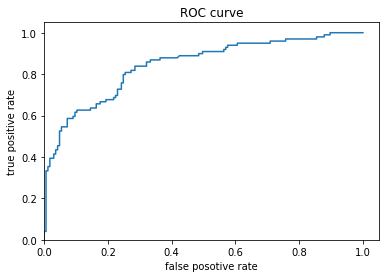

In [27]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false posotive rate')
plt.ylabel('true positive rate')
plt.xlim(0, )
plt.ylim(0, )